In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from typing import Union, List
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import re


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *
from feature_engineering import *



In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
#listings_raw = pd.read_csv("../data/raw/munich/2020-06-20/listings.csv.gz",compression="gzip")
listings_raw = pd.read_csv("../data/raw/munich/2020-03-19/listings.csv.gz",compression="gzip")
#listings_raw = pd.read_csv("../data/raw/munich/2019-11-25/listings.csv.gz",compression="gzip")


In [91]:
listings = listings_raw.copy()

In [92]:
# Format price
listings["price"] = format_price(listings["price"])
listings["cleaning_fee"] = format_price(listings["cleaning_fee"])
listings["cleaning_fee"] = listings["cleaning_fee"].fillna(0)
listings["extra_people"] = format_price(listings["extra_people"])
listings["security_deposit"] = format_price(listings["security_deposit"])

In [93]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

In [94]:
# drop inactive listings
listings = listings[listings["availability_365"]!=0]

In [95]:
# drop duplicates. sort by id first to ensure the latest listing is used.
listings.sort_values(by="id").drop_duplicates(subset=["price","description","space","name"], keep='last', inplace=True)

In [96]:
# Drop outliers
def drop_outliers(listings, min_quantile=0.0001, max_quantile=0.9):
    listings = listings[listings["price"] < listings["price"].quantile(max_quantile)]
    listings = listings[listings["price"] > listings["price"].quantile(min_quantile)]
    return listings

listings = drop_outliers(listings)

In [97]:
listings["square_feet"].isna().sum() / len(listings)

0.9798973481608212

In [98]:
# extract size of the airbnb from description field, since square_feet is missing in most cases

# extract numbers 
listings['description'] = listings['description'].str.replace("MBit|Mbit|mbit|Min|min|minutes|minute|meter"," ") # remove everything definitely related to time to avoid confusions between size unit and time unit
#listings['description'] = listings['description'].str.replace("\d.\d"," ", regex=True)

#(\d{2,3}\s*?[sm²SMq])
listings['size'] = listings['description'].str.extract(u'(\d{2,3}\s*?(m²|qm|sq|sm|quadratmeter|meter²|meters²))',expand=True, flags=re.IGNORECASE)[0]
listings['size'] = listings['size'].str.replace("\D", "")

# change datatype of size into float
listings['size'] = listings['size'].astype(float)

# convert to square meters
listings["square_feet"]= listings["square_feet"] / 10.764

# if square_feet is not missing, use it as size
listings["size"] = np.where(listings["size"].isna()&listings["square_feet"].notna(), listings["square_feet"], listings["size"])



In [99]:
def text_contains_word(df: pd.DataFrame, search_features: Union[str, List[str]], word: Union[str,List[str]], feature_name: str) -> pd.DataFrame:
    """
    Checks if at least one of the given features contains a given word.

    Input:
    - df: pd.DataFrame
    - search_features: names of columns with text data
    - word: str or list of words to search in the features
    - feature_name: name of new feature

    Returns:
    - pd.DataFrame with a new column named after the given words and representing a true/false flag.
    """
    if isinstance(word, list):
        word = [w.lower() for w in word]
        search_term = "|".join(word) # pipe for "or"-search
    else:
        search_term = word.lower()

    df[search_features] = df[search_features].apply(lambda x: x.str.lower())
    df[feature_name] = df[search_features].apply(lambda x: any(x.str.contains(search_term) & x.notna()), axis=1)
    return df

In [100]:
def mean_price(df: pd.DataFrame, feature):
    """Get mean price grouped by the given feature."""
    return df.groupby(feature).price.mean(),df.groupby(feature).price.median(), df[feature].value_counts()

In [101]:
def format_flags(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Format t / f to boolean True and False
    """
    flags = {"t": True, "f": False, "nan": np.NaN}
    for col in columns:
        df[col] = df[col].replace(flags)
        df[col] = df[col].astype(bool)
    return df

In [102]:
def make_dummies(series: pd.Series, name: str, sep="|") -> pd.DataFrame:
    """
    Performs one-hot encoding and renames the resulting columns by prepending the name parameter to column names
    """
    dummies = series.str.get_dummies(sep=sep)
    dummies.columns = name + dummies.columns
    for col in dummies.columns:
        dummies[col] = dummies[col].astype(bool)
    return dummies

In [103]:
# Check if AirBnb has a root-top terrace which could increase the price
words = ["roof top", "roof-top", "Dachterasse","Dachterrasse","roof terrace"]
descriptive_columns = ["space", "description"]
listings = text_contains_word(listings, descriptive_columns, words, "roof_top_terrace")
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [104]:
listings.groupby("roof_top_terrace").price.agg([np.mean, np.median])

,mean,median
roof_top_terrace,,
False,85.290466,75.0
True,91.589043,80.0


In [105]:
# Perform one-hot encoding for amenities
amenities = listings_raw.amenities.str.replace("[{""}]", "")\
                    .str.replace("\"", "")
amenities = make_dummies(amenities, name="amenities_",sep=",")
amenities["total_amount_amenities"] = amenities.sum(axis=1)

# Add (one-hot encoded) amenity features to dataset
listings = pd.concat([listings, amenities], axis=1)


In [106]:
listings.columns[listings.columns.str.contains("amenities_")]

Index(['amenities_ toilet', 'amenities_24-hour check-in',
       'amenities_Accessible-height bed', 'amenities_Accessible-height toilet',
       'amenities_Air conditioning', 'amenities_Air purifier',
       'amenities_BBQ grill', 'amenities_Baby bath', 'amenities_Baby monitor',
       'amenities_Babysitter recommendations',
       ...
       'amenities_Wide doorway to guest bathroom', 'amenities_Wide entrance',
       'amenities_Wide entrance for guests', 'amenities_Wide entryway',
       'amenities_Wide hallways', 'amenities_Wifi', 'amenities_Window guards',
       'amenities_Wine cooler',
       'amenities_translation missing: en.hosting_amenity_49',
       'amenities_translation missing: en.hosting_amenity_50'],
      dtype='object', length=146)

In total there are 146 different amenities --> a lot of additional features.

In [107]:
# Calculate elapsed time since the host is active on AirBnb
listings["host_since_month"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["host_since"])).astype('timedelta64[M]')

In [108]:
# Calculate elapsed time since first review and last review
listings["time_since_first_review"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["first_review"])).astype('timedelta64[D]')
listings["time_since_last_review"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["last_review"])).astype('timedelta64[D]')

In [109]:
# check if host lives in Munich and thus at least nearby the AirBnb
listings = text_contains_word(listings, ["host_location"], ["Munich", "München"], "host_in_munich")


In [110]:
listings["cancellation_policy"].value_counts()

strict_14_with_grace_period    1752
flexible                       1558
moderate                       1362
super_strict_60                   2
strict                            1
super_strict_30                   1
Name: cancellation_policy, dtype: int64

A few policies occur very seldom --> replace them

In [111]:
# Replace cancellation policies that are seldom
listings["cancellation_policy"].replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [112]:
# since response time is an ordinal feature (the shorter the better) we encode the categories with integers
# missing values are additionally encoded in an "unknown"-variable
listings["response_time_unknown"] = listings["host_response_time"].isna()

response_time_encoding = {"within an hour": 1,
                          "within a few hours": 2,
                          "within a day": 3,
                          "a few days or more": 4}#"nan": 99999}
listings.host_response_time.replace(response_time_encoding, inplace=True)


In [113]:
# remove %-sign from features containing rates
listings["host_response_rate"] = listings["host_response_rate"].astype(str).str.replace("%","").astype(float)
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].astype(str).str.replace("%","").astype(float)



In [114]:
listings["host_in_different_neighbourhood"] = listings["host_neighbourhood"] != listings["neighbourhood"]

In [116]:
# Get flag columns and reformat them to booleans
flag_cols = listings.apply(lambda x: 'f' in x.dropna().unique() or 't' in x.dropna().unique()).loc[lambda x: x==True].index.values
listings = format_flags(listings, flag_cols)

In [117]:
# encode host verification
listings["host_verifications"] = listings["host_verifications"].str.replace("\[|\]|'| ","")
host_verification_encoding = make_dummies(listings["host_verifications"], name="", sep=",")
# build a group of encoded host verifications with just a few samples
other = host_verification_encoding.sum().loc[lambda x: x<1000].index.values
host_verification_encoding["other"] = host_verification_encoding[other].any(axis=1)
host_verification_encoding.drop(columns=other, inplace=True)
host_verification_encoding.columns = "host_verification_" + host_verification_encoding.columns#

listings = pd.concat([listings, host_verification_encoding], axis=1)

In [118]:
listings["property_type"] = listings["property_type"].astype(str)

In [119]:
# group seldom property types
listings["property_type"] = listings["property_type"].replace({"Townhouse" : "House", "Bungalow": "House", 'Bungalow': 'House', 'Cottage': 'House','Villa': 'House', 'Tiny house': 'House', 'Earth house': 'House','Chalet': 'House',
 "Aparthotel": "Hotel", "Boutique hotel": "Hotel",
 "Serviced apartment" : "Apartment", "Condominium" : "Apartment", "Loft" : "Apartment"})

listings.loc[~listings["property_type"].isin(["House","Apartment","Hotel"]), "property_type"] = "Other"

In [120]:
# use zipcode directly as discrete variable since the codes provide information about how far away one zipcode is from another
listings["zipcode"] = listings["zipcode"].astype(str).str[:5] # make sure that the zipcode contains 5 digits
listings["zipcode"] = listings["zipcode"].astype(float)

In [121]:
#listings.room_type.value_counts(normalize=True)
room_type = make_dummies(listings["room_type"], name="room_type_")
listings = pd.concat([listings, room_type], axis=1)

In [122]:
#listings.bed_type.value_counts(normalize=True)
bed_type = make_dummies(listings["bed_type"], name="bed_type_")
listings = pd.concat([listings, bed_type], axis=1)

In [123]:
#listings.cancellation_policy.value_counts(normalize=True)
cancellation_policy = make_dummies(listings["cancellation_policy"], name="cancellation_policy_")
listings = pd.concat([listings, cancellation_policy], axis=1)

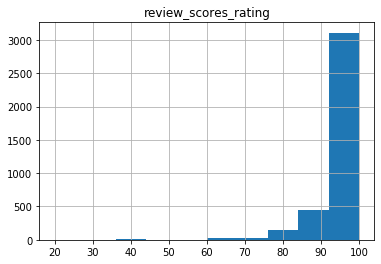

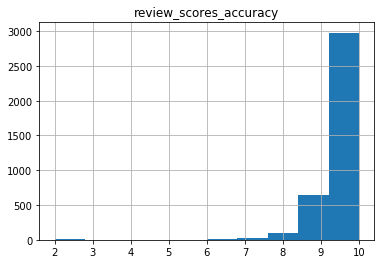

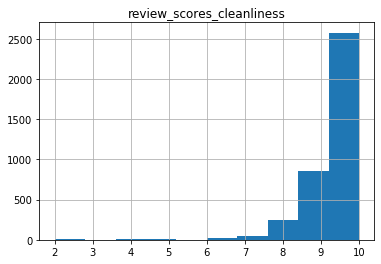

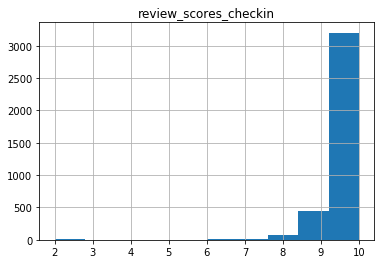

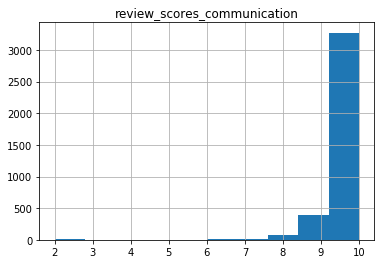

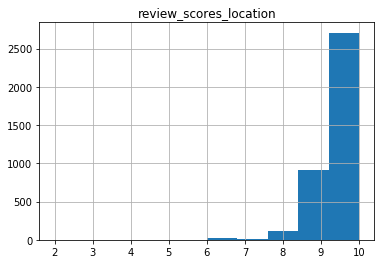

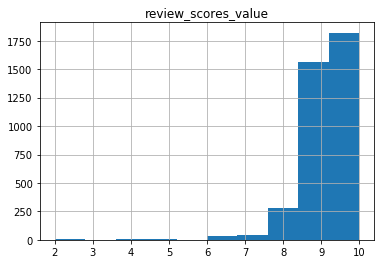

Index(['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')


In [124]:
for col in listings.columns[listings.columns.str.contains("score")]:
    listings[col].hist()
    plt.title(col)
    plt.show()
print(listings.columns[listings.columns.str.contains("score")])

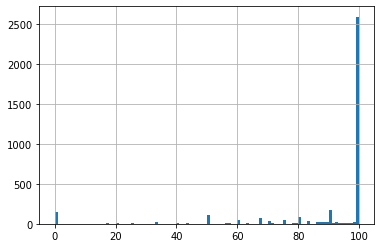

In [125]:
listings.host_response_rate.hist(bins=100)
#plt.xlim(85,100)

In [126]:
def make_bins(df, col, bins, labels, one_hot_encoded=False):
    """Bins the series into the given bins. The first bin starts with 0."""
    bins = pd.cut(df[col], bins=bins, include_lowest=True)
    if one_hot_encoded:
        categoricals = pd.get_dummies(bins).astype(bool)
        categoricals.columns = labels
        return categoricals
    return bins

def add_binning_features(listings):
    for col in ['review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value']:
        labels = [col + "_0-8", col + "_9", col + "_10"]
        bins = make_bins(listings, col, bins=[0,8,9,10], labels=labels, one_hot_encoded=True)
        listings = pd.concat([listings, bins], axis=1)

    col = "review_scores_rating"
    labels = [col + "_0-79", col + "_80-89", col + "_90-100"]    
    bins = make_bins(listings, col, bins=[0,80,90,100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    col = "host_response_rate"
    labels = [col + "_" + bin for bin in ["0-50","50-89", "90-99","100"]]
    bins = make_bins(listings, col, bins=[0, 50, 90, 99, 100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    col = "host_acceptance_rate"
    labels = [col + "_" + bin for bin in ["0-50","50-89", "90-99","100"]]
    bins = make_bins(listings, col, bins=[0, 50, 90, 99, 100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    listings.drop(columns=['review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value','review_scores_rating','host_response_rate','host_acceptance_rate'], inplace=True)

    return listings



In [127]:
listings = add_binning_features(listings)

In [128]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    See:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-pointshttps://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_to_point_of_interest(df):
    points_of_interest = {"oktoberfest_geo_location": (48.130910, 11.548901),
    "munich_main_station_geo_location": (48.140283, 11.560488),
    "munich_hofbraeuhaus_geo_location": (48.137612, 11.579911),
    "munich_englischer_garten_geo_location": ( 48.152066, 11.592246 ),
    "munich_deutsches_museum_geo_location": ( 48.129929, 11.583482 ),
    "munich_marienplatz_geo_location": (48.137326, 11.575377)}

    for poi, coords in points_of_interest.items():
        df[poi] = df.apply(lambda x: haversine(x["longitude"], x["latitude"], coords[1], coords[0]), axis=1)

    return df

In [129]:
listings = distance_to_point_of_interest(listings)

In [130]:
listings["average_poi_distance"] = listings.apply(lambda x: x[x.index.str.contains("geo_location")].mean(),axis=1)

In [131]:
# drop listings without latitude / longitude
listings = listings.dropna(subset=["latitude","longitude"])

In [132]:
# Group some of the amenities
listings["amount_white_goods"] = listings['amenities_Washer'].astype(int)  + listings['amenities_Dishwasher'].astype(int) + listings['amenities_Washer/Dryer'].astype(int)
listings["amount_baby_equipment"] = listings['amenities_Changing table'].astype(int) + listings['amenities_Crib'].astype(int) + listings['amenities_High chair'].astype(int) + listings['amenities_Baby bath'].astype(int) + listings['amenities_Baby monitor'].astype(int) + listings['amenities_Babysitter recommendations'].astype(int)


listings["amenities_TV"] = listings['amenities_TV'] | listings['amenities_Smart TV'] | listings['amenities_Cable TV']
listings.drop(columns=['amenities_Cable TV', 'amenities_Smart TV'], inplace=True)

listings["amenities_Washer"] = listings['amenities_Washer'] | listings['amenities_Washer/Dryer']
listings.drop(columns=['amenities_Washer/Dryer'], inplace=True)

listings["amenities_Kitchen"] = listings['amenities_Kitchen'] | listings['amenities_Full kitchen'] | listings['amenities_Kitchenette']
listings.drop(columns=['amenities_Full kitchen', 'amenities_Kitchenette'], inplace=True)

listings["amenities_baby_equipment"] = listings['amenities_Changing table'] | listings['amenities_Crib'] | listings['amenities_High chair'] | listings['amenities_Baby bath'] | listings['amenities_Baby monitor'] | listings['amenities_Babysitter recommendations']
listings.drop(columns=['amenities_Changing table','amenities_Crib', 'amenities_High chair'], inplace=True)

listings["amenities_Pets live on this property"] = listings["amenities_Pets live on this property"] | listings['amenities_Dog(s)'] | listings['amenities_Cat(s)']
listings.drop(columns=['amenities_Dog(s)','amenities_Cat(s)'], inplace=True)



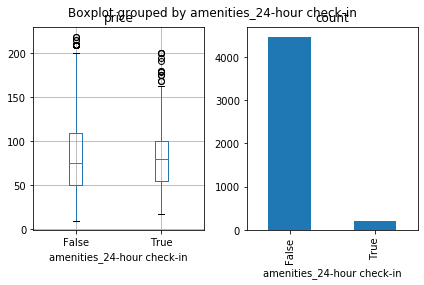

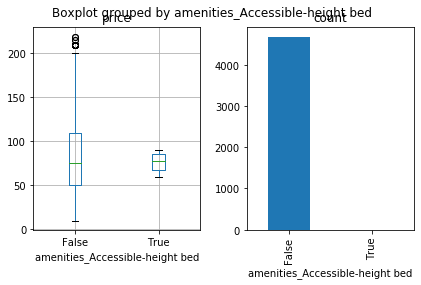

In [133]:
for col in listings.columns[listings.columns.str.contains("amenities_")][1:3].values:
    fig, (ax1, ax2) = plt.subplots(1,2)
    listings.boxplot(column="price", by=col,ax=ax1, grid=True)
    #listings.groupby(col).price.median().plot.bar(ax=ax1, title="price")
    listings.groupby(col).price.count().plot.bar(ax=ax2, title="count")
    plt.tight_layout()
    plt.show()

In [134]:
# Manually select amenities by domain knowledge
selected_amenities = [
'amenities_Air conditioning',
'amenities_BBQ grill',
'amenities_TV',
'amenities_Washer',
'amenities_Family/kid friendly',
'amenities_Kitchen',
'amenities_Garden or backyard',
'amenities_Gym',
'amenities_Laptop-friendly workspace',
'amenities_Patio or balcony',
'amenities_Wide entrance for guests','amenities_Elevator',
'amenities_Breakfast',
"amenities_Pets live on this property",
"amenities_baby_equipment",
"amount_baby_equipment"
"amount_white_goods",
"amenities_Bathtub",
"amenities_Carbon monoxide alarm",
"amenities_Indoor fireplace",
"amenities_Free street parking",
"amenities_Long term stays allowed",
"amenities_No stairs or steps to enter",
"amenities_Private entrance",
"amenities_Pool",
"total_amount_amenities"]


In [135]:
listings["total_missing_values"] = listings.isna().sum(axis=1)

In [136]:
# Drop columns with >80% NaNs
listings.drop(columns=(listings.isna().sum() / len(listings)).loc[lambda x: x>0.8].index.values, inplace=True)

In [137]:
# Remove features with only one observed value
listings.drop(columns=listings.apply(lambda x: x.nunique() <= 1).loc[lambda x: x==True].index.values, inplace=True)

In [138]:
def plot_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    print(corr.shape)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10,10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


#plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")]])

(8, 8)


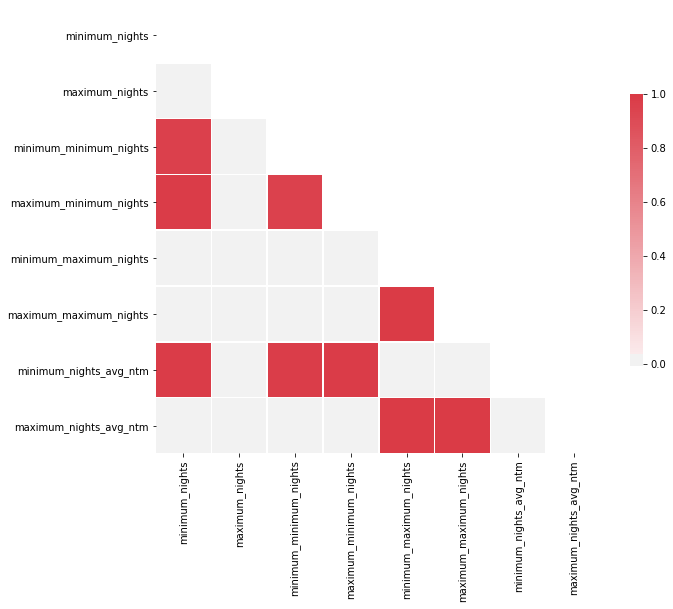

In [139]:
plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("night")]])

In [140]:
def get_correlated_features(df, threshold=0.8):
    """
    """
    correlation_matrix = df.corr()
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        #corr_dict[correlation_matrix.columns[i]] = set()
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname != correlation_matrix.index[j]:
                    correlated_features.add(colname)
    return correlated_features

#corr_f = filter_correlated_features(listings, 0.8)

In [141]:
amenities_to_drop = set(listings.columns[listings.columns.str.contains("ameniti")] )- set(selected_amenities)
amenities_to_drop 

{'amenities',
 'amenities_ toilet',
 'amenities_24-hour check-in',
 'amenities_Accessible-height bed',
 'amenities_Accessible-height toilet',
 'amenities_Baby bath',
 'amenities_Baby monitor',
 'amenities_Babysitter recommendations',
 'amenities_Baking sheet',
 'amenities_Barbecue utensils',
 'amenities_Bath towel',
 'amenities_Bathroom essentials',
 'amenities_Beach essentials',
 'amenities_Beachfront',
 'amenities_Bed linens',
 'amenities_Bedroom comforts',
 'amenities_Body soap',
 'amenities_Bread maker',
 'amenities_Building staff',
 'amenities_Buzzer/wireless intercom',
 'amenities_Carbon monoxide detector',
 'amenities_Children’s books and toys',
 'amenities_Children’s dinnerware',
 'amenities_Cleaning before checkout',
 'amenities_Coffee maker',
 'amenities_Cooking basics',
 'amenities_Disabled parking spot',
 'amenities_Dishes and silverware',
 'amenities_Dishwasher',
 'amenities_Doorman',
 'amenities_Dryer',
 'amenities_EV charger',
 'amenities_Espresso machine',
 'amenities_E

In [142]:
listings.drop(columns=amenities_to_drop, inplace=True)

In [143]:
len(listings.columns[listings.columns.str.contains("amenities_")])

21

Only 21 amenity features are left.

In [144]:
# Check if there are correlations between neighbourhoods (e.g. when some parts of the city belong to one bigger area)
correlated_neighbourhoods = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("neighbourhood")&~listings.columns.str.contains("host")]], 0.8)
correlated_neighbourhoods

set()

In [145]:
# Calculate correlations between amenities
correlated_amenities = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")&~listings.columns.str.contains("total")]], 0.6)
correlated_amenities

{'amenities_Wide entrance for guests'}

In [146]:
correlated_rest = get_correlated_features(listings.loc[:,listings.columns[~listings.columns.str.contains("amenities")&~listings.columns.str.contains("neighbourhood")]], 0.8)
correlated_rest.remove('average_poi_distance')
correlated_rest.remove('munich_marienplatz_geo_location')
correlated_rest

{'availability_60',
 'availability_90',
 'bed_type_Real Bed',
 'calculated_host_listings_count_entire_homes',
 'host_since_month',
 'host_total_listings_count',
 'host_verification_jumio',
 'host_verification_selfie',
 'maximum_maximum_nights',
 'maximum_minimum_nights',
 'maximum_nights_avg_ntm',
 'minimum_minimum_nights',
 'minimum_nights_avg_ntm',
 'munich_deutsches_museum_geo_location',
 'munich_englischer_garten_geo_location',
 'munich_hofbraeuhaus_geo_location',
 'munich_main_station_geo_location',
 'reviews_per_month',
 'room_type_Private room',
 'time_since_first_review'}

In [147]:
listings.drop(columns=correlated_neighbourhoods, inplace=True)
#listings.drop(columns=correlated_host_neighbourhoods, inplace=True)
listings.drop(columns=correlated_amenities, inplace=True)
listings.drop(columns=correlated_rest, inplace=True)

In [148]:
listings["interaction_unknown"] = listings["interaction"].isna()

In [149]:
drop_cols = ['listing_url',
            'scrape_id',
            'last_scraped',
            'thumbnail_url', 
            'medium_url',
            'picture_url', 
            'xl_picture_url',
            'host_thumbnail_url', 
            'host_picture_url',
            'calendar_last_scraped',
            'name',
            'summary',
            'scrape_id',
            'country_code',
            'country',
            'amenities',
            'space',
            'description',
            'id',
            'neighborhood_overview',
            'notes',
            'transit',
            'experiences_offered',
            'host_since',
            'access', 
            'interaction',
            'house_rules',
            'host_id',
            'host_url',
            'host_name',
            'host_location',
            'host_about',
            'host_neighbourhood',
            'host_has_profile_pic',
            'neighbourhood',
            'host_verifications',
            'street',
            'zipcode',
            'city',
            'market', 
            'smart_location',
            'property_type',
            'state',
            'weekly_price',
            'monthly_price',
            #'security_deposit',
            #'cleaning_fee',
            #'extra_people',
            'calendar_updated',
            'first_review',
            'last_review',
            'bed_type',
            'room_type',
            'cancellation_policy',
            'neighbourhood_cleansed',
            'license',
            'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value',
       'is_location_exact',
       'maximum_nights', 'minimum_maximum_nights'
            ]
listings.drop(columns=drop_cols, inplace=True, errors='ignore')

In [150]:
def get_low_variance_binary_features(df, threshold):
    """
    Returns all features with variance <= threshold.
    """
    rare = []
    for col in df.columns:
        if df[col].var() <= threshold:
            rare.append(col)
    return rare

In [153]:
rare_features = get_low_variance_binary_features(listings.select_dtypes("bool"), threshold=0.01)

In [154]:
rare_features

['amenities_Pool',
 'host_verification_phone',
 'bed_type_Airbed',
 'bed_type_Couch',
 'bed_type_Futon']

In [155]:
listings.drop(columns=rare_features, inplace=True, errors="ignore")
#listings.drop(columns=amenities_to_drop, errors="ignore", inplace=True)
listings.drop(columns=listings.columns[listings.columns.str.contains("host_neighbourhood")].values, inplace=True)
listings.drop(columns=listings.columns[listings.columns.str.contains("host_verification_")],inplace=True)

In [156]:
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [157]:
# reduce granularity of latitude / longitude since very high accuracy is not neccessary
listings["latitude"] = np.round(listings["latitude"],4)
listings["longitude"] = np.round(listings["longitude"],4)

In [331]:
listings.shape

(4676, 95)

In [341]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns=["price"]), listings["price"], test_size=0.2, random_state=42, shuffle=True)

numerical_features = X_train.select_dtypes(np.number).columns

# Only impute numerical columns with IterativImputer (uses BayesianRidgeRegression)
imputation = ColumnTransformer([("numerical_features", IterativeImputer(max_iter=30, random_state=0, n_nearest_features=10), numerical_features)], remainder="passthrough")

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',n_jobs=-1)
pipeline = Pipeline(steps=[("imputation", imputation),
                    ("xgb", xgb_regressor )])



In [159]:

param_grid = {'xgb__n_estimators': [1500, 2000, 3000],
              'xgb__learning_rate': [0.01, 0.05, 0.1], 
              'xgb__max_depth': [3, 6, 8],
              'xgb__colsample_bytree': [0.6, 0.7, 0.8],
              'xgb__subsample': [0.8,0.9],
              'xgb__min_child_weight': [5,10,15],
              'xgb__reg_alpha': [0, 0.5, 1],
              'xgb__reg_lambda': [2, 3, 4, 5],
              'xgb__gamma': [0.0, 0.2, 0.5]}

# total of 17496 possible parameter combinations
# use randomized search to limit the number of iterations and save time
param_search = RandomizedSearchCV(pipeline, param_grid, cv=3, verbose=True, n_iter=2000, n_jobs=-1)
# perform parameter search
param_search.fit(X_train, y_train)


Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 109.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 150.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 196.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 253.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 317.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 385.1min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('imputation',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numerical_features',
                                                                               IterativeImputer(max_iter=30,
                                                                                                n_nearest_features=10,
                                                                                                random_state=0),
                                                                               Index(['host_response_time', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cle...
                                                           verbosity=None))]),
                   n_iter=2000, n_jobs=-1,
               

In [177]:
param_search.best_params_

{'xgb__subsample': 0.8,
 'xgb__reg_lambda': 4,
 'xgb__reg_alpha': 0,
 'xgb__n_estimators': 1500,
 'xgb__min_child_weight': 5,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.01,
 'xgb__gamma': 0.0,
 'xgb__colsample_bytree': 0.6}

best set of parameters found:
```python
{'xgb__subsample': 0.8,
 'xgb__reg_lambda': 4,
 'xgb__reg_alpha': 0,
 'xgb__n_estimators': 1500,
 'xgb__min_child_weight': 5,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.01,
 'xgb__gamma': 0.0,
 'xgb__colsample_bytree': 0.6}
```


In [342]:
pipeline.set_params(**param_search.best_params_)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_features',
                                                  IterativeImputer(max_iter=30,
                                                                   n_nearest_features=10,
                                                                   random_state=0),
                                                  Index(['host_response_time', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extr...
                              colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=6, min_child_weight=5,
                              missing=nan,

In [343]:
pipeline.score(X_test,y_test)

0.4987248518779963

In [344]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    r2_train = r2_score(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    mse_train = mean_squared_error(y_train, pred_train)

    r2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mse_test = mean_squared_error(y_test, pred_test)

    fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,7))
    ax1.scatter(y_test, y_test - pred_test)
    ax1.set_ylabel("residual")
    ax1.set_xlabel("y_test")
    ax1.set_title("true-pred")

    #ax2.scatter(y_test, pred_test)
    sns.regplot(x=y_test, y=pred_test, ax=ax2)
    ax2.plot(np.arange(0,np.max(y_test), 1),np.arange(0,np.max(y_test), 1))
    ax2.set_ylabel("y_pred")
    ax2.set_xlabel("y_test")
    ax2.set_title("true vs pred (test set)")

    sns.regplot(x=y_train, y=pred_train, ax=ax3)
    ax3.plot(np.arange(0,np.max(y_train), 1),np.arange(0,np.max(y_train), 1))
    ax3.set_ylabel("y_pred")
    ax3.set_xlabel("y_train")
    ax3.set_title("true vs pred (train set)")

    #fig.suptitle("r2="+str(r2_test))
    plt.tight_layout()
    plt.show()

    print("r2 train: " + str(r2_train))
    print("mae train: " + str(mae_train))
    print("mse train: " + str(mse_train))

    print("r2 test: " + str(r2_test))
    print("mae test: " + str(mae_test))
    print("mse test: " + str(mse_test))

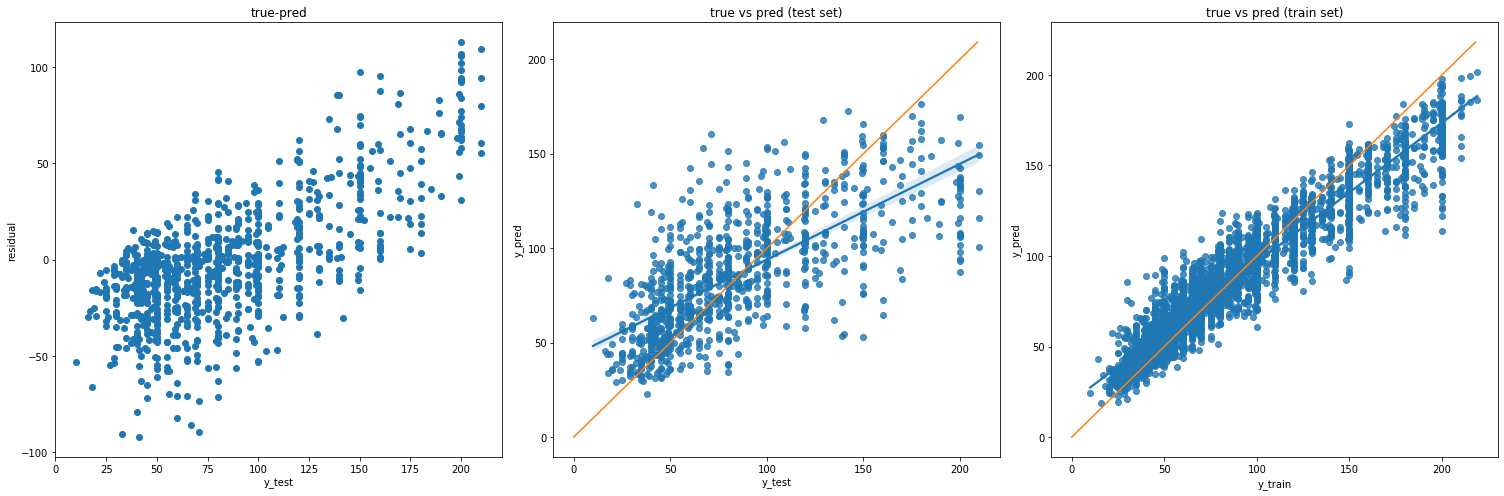

r2 train: 0.8835344754881391
mae train: 10.874956
mse train: 227.31213
r2 test: 0.4987248518779963
mae test: 23.003256
mse test: 976.6761


In [345]:
evaluate_model(pipeline, X_train, X_test, y_train, y_test)

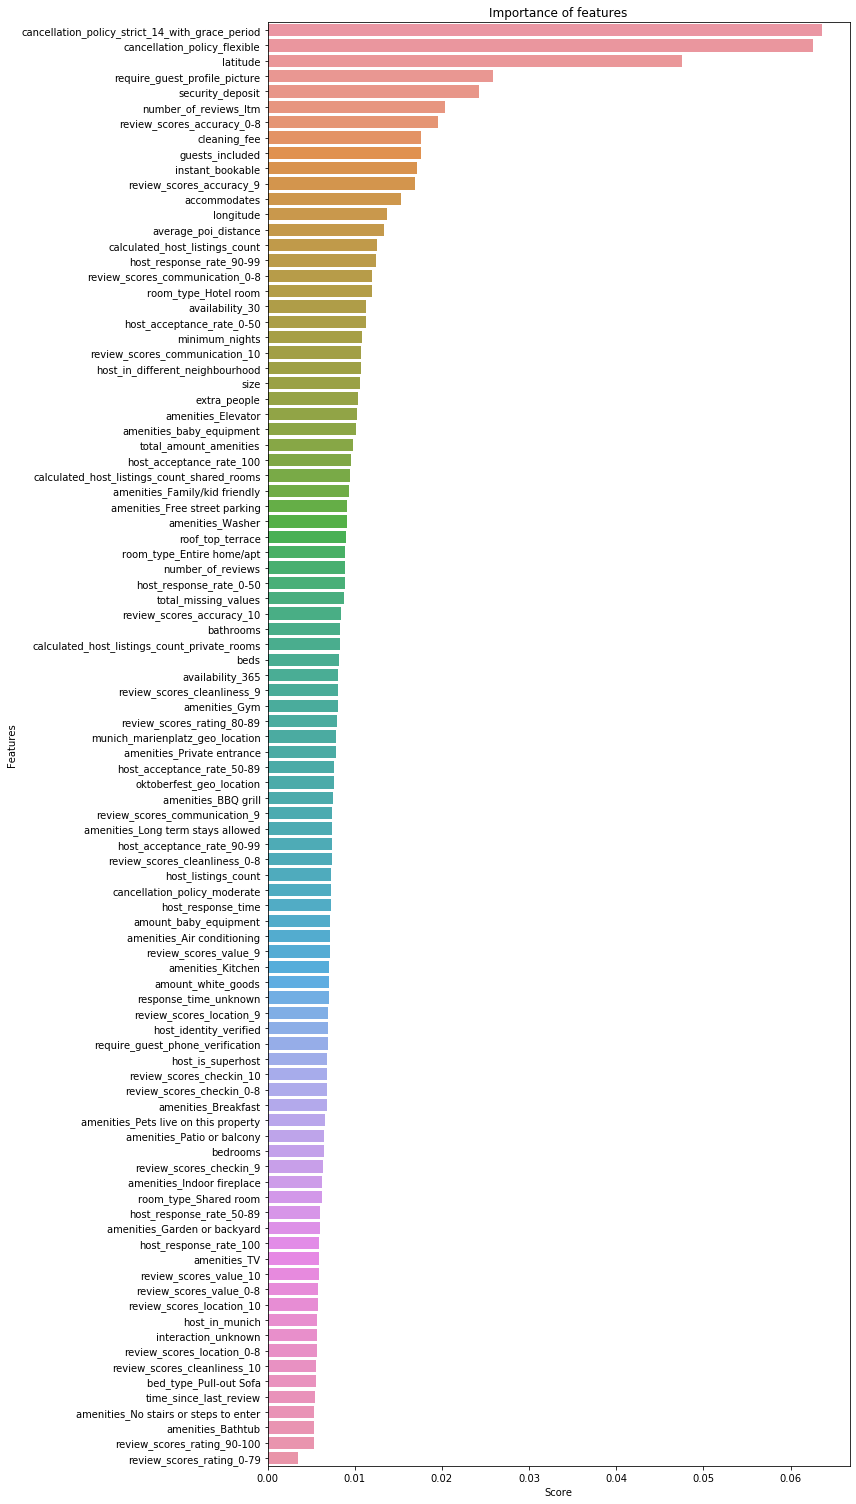

In [346]:
# Sort the importance of the features
importances = xgb_regressor.feature_importances_
    
values = sorted(zip(X_train.columns, xgb_regressor.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature']
y_feature = np.arange(len(features))
score = feature_importances['score']

# Plot the importance of a feature to the price
plt.figure(figsize=(12,21));
sns.barplot(x=score, y=features) 
plt.ylabel('Features');
plt.xlabel('Score');
plt.title('Importance of features');
plt.tight_layout()
plt.show()
#plt.savefig("../img/feature_importance.png", dpi=300)

In [275]:
xgb_regressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [276]:
import shap


In [277]:
subset = shuffle(X_test)

In [278]:
# fixes a bug in the shap lib
mybooster = xgb_regressor.get_booster()
model_bytearray = mybooster.save_raw()[4:]

def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

In [309]:


# create explanation model
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(subset)


In [333]:
%matplotlib

In [327]:
shap.summary_plot(shap_values, subset, max_display=len(X_test.columns), show=False)

In [328]:
plt.savefig("../img/shap_summary_plot.png", bbox_inches='tight')